# PrimeKG knowledge graph query and answer using embedding

Query a knowledge graph for drugs/diseases using embedding

**references:**


databases:
- PrimeKG knowledge graph: https://github.com/mims-harvard/PrimeKG
- STaRK question/answers: https://github.com/snap-stanford/stark
  - database explanation: https://stark.stanford.edu/dataset_prime.html

modules:
- embedding using Sentence Transformer: https://www.sbert.net/docs/quickstart.html
- project using these databases:
  - https://github.com/VirtualPatientEngine/AIAgents4Pharma
  - https://virtualpatientengine.github.io/AIAgents4Pharma/notebooks/talk2knowledgegraphs/tutorial_starkqa_primekg_textual_embeddings_nomic_embed_text/


## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import os.path

In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def random_mask(n,k):
    a = np.zeros(n, dtype=bool)
    a[:k] = 1
    np.random.shuffle(a)
    return a

## load dataset

In [3]:
primekg = pd.read_csv("kg.csv", low_memory=False)

In [4]:
primekg

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI
...,...,...,...,...,...,...,...,...,...,...,...,...
8100493,anatomy_protein_absent,expression absent,66747,4720,anatomy,cerebellar vermis,UBERON,5259,140,gene/protein,ADORA3,NCBI
8100494,anatomy_protein_absent,expression absent,63824,1377,anatomy,quadriceps femoris,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100495,anatomy_protein_absent,expression absent,63826,1379,anatomy,vastus lateralis,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100496,anatomy_protein_absent,expression absent,64523,2084,anatomy,heart left ventricle,UBERON,58254,105378952,gene/protein,KLF18,NCBI


## create nodes dataframe and edges index

In [5]:
nodes1 = primekg[["x_index", "x_name", "x_type"]].rename(columns={"x_index":"indx","x_name":"name","x_type":"type"})
nodes2 = primekg[["y_index", "y_name", "y_type"]].rename(columns={"y_index":"indx","y_name":"name","y_type":"type"})
nodes = pd.concat([nodes1,nodes2]).drop_duplicates().reset_index(drop=True)
nodes = nodes.sort_values(by="indx").reset_index(drop=True)
nodes

,indx,name,type
0,0,PHYHIP,gene/protein
1,1,GPANK1,gene/protein
2,2,ZRSR2,gene/protein
3,3,NRF1,gene/protein
4,4,PI4KA,gene/protein
...,...,...,...
129370,129370,Ion transport by P-type ATPases,pathway
129371,129371,Inhibition of voltage gated Ca2+ channels via...,pathway
129372,129372,anatomical entity,anatomy
129373,129373,multi-cellular organism,anatomy


In [6]:
if not np.all(nodes.index == nodes["indx"]):
    raise IOError("error")

In [7]:
nodes.drop(columns="indx", inplace=True)

In [8]:
edges = primekg[["x_index","y_index"]].values
edges.shape

(8100498, 2)

In [9]:
len(nodes)/len(edges)

0.015971240286708297

## convert to text and transform to embedding

### enrichment (textual representation)

In [10]:
%%time
enriched_nodes = ["{} belongs to {} category.".format(n["name"],n["type"]) for i,n in tqdm(nodes.iterrows(), total=len(nodes))]

100%|█████████████████████████████████████████████████████| 129375/129375 [00:08<00:00, 15252.26it/s]

CPU times: user 8.44 s, sys: 89.7 ms, total: 8.53 s
Wall time: 8.49 s


In [11]:
# apply to dataframe
# nodes["text"] = enriched_nodes
# nodes

### embedding

#### transformer model

In [12]:
batch_size = 10 # for embedding

In [13]:
from sentence_transformers import SentenceTransformer

/home/pascal/python_virtual_environments/kg/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [14]:
model = SentenceTransformer("all-MiniLM-L6-v2")

#### apply embedding

##### nodes

In [15]:
%%time
embeddings_nodes = []
#for i in tqdm(range(0,len(nodes),batch_size)):
#sentences = nodes.iloc[i:i+batch_size]["text"].values.tolist() # enriched_nodes
for i in tqdm(range(0,len(enriched_nodes),batch_size)):
    sentences = enriched_nodes[i:i+batch_size]
    embeddings_batch = model.encode(sentences)
    embeddings_nodes.extend(embeddings_batch)

len(embeddings_nodes)

100%|██████████████████████████████████████████████████████████| 12938/12938 [02:35<00:00, 83.40it/s]

CPU times: user 3min 49s, sys: 28.3 s, total: 4min 17s
Wall time: 2min 35s


129375

In [32]:
%%time
nodes["embedding"] = embeddings_nodes

CPU times: user 44.4 ms, sys: 59.2 ms, total: 104 ms
Wall time: 102 ms


In [33]:
embeddings_nodes_fn = "embeddings_nodes.parquet"

In [34]:
%%time
if not os.path.isfile(embeddings_nodes_fn):
    print("save to file: {}".format(embeddings_nodes_fn))
    nodes.to_parquet(embeddings_nodes_fn)

CPU times: user 48 µs, sys: 6 µs, total: 54 µs
Wall time: 54.1 µs


In [35]:
embeddings_nodes = np.array(embeddings_nodes)
embeddings_nodes.shape

(129375, 384)

##### edges

In [18]:
%%time
embeddings_edges = []
for i in tqdm(range(0,len(enriched_edges),batch_size)):
    sentences = enriched_edges[i:i+batch_size]
    embeddings_batch = model.encode(sentences)
    embeddings_edges.extend(embeddings_batch)

len(embeddings_edges)

NameError: name 'enriched_edges' is not defined

In [19]:
%%time
primekg["embedding"] = embeddings_edges
primekg.to_parquet("embeddings_edges.parquet")

ValueError: Length of values (0) does not match length of index (8100498)

In [20]:
embeddings_edges = np.array(embeddings_edges)
embeddings_edges.shape

(0,)

## query knowledge graph

### load data

The `stark_qa` database contains query and answer pairs. The `answer_ids` are nodes in the `primekg` graph.
Some queries have several possible answers (a list).

In [21]:
# load qa database
# stark_qa : (question,answer) pairs
starkqa_df = pd.read_csv("stark_qa.csv", converters={"answer_ids": lambda x: list(map(int,x.strip("[]").split(", ")))})
starkqa_df

,id,query,answer_ids
0,10328,"Which medications, designed to target genes or...",[18423]
1,11172,Identify pathways associated with the activati...,[62404]
2,2260,I'm looking for tablet or capsule medications ...,[18967]
3,2304,Can you identify genes and proteins associated...,[1636]
4,11016,Which medication acts by engaging with genes o...,"[16589, 16590, 16591, 16592, 14801, 16595, 14717]"
...,...,...,...
11199,8752,Find health conditions linked to diacylglycero...,[33575]
11200,9974,What are the observed effects or phenotypes as...,"[94246, 33738, 94374, 93734]"
11201,8636,What are the observed effects or phenotypes as...,"[23000, 23091, 25269]"
11202,9810,Identify genes or proteins that interact with ...,"[5720, 4550]"


### Method 1: linear decomposition of query in QA pairs and interpolate the answer

- Get the embedding of all queries from the `stark_qa` database. Matrix: `embeddings_queries`.
- For a custom query, project its embedding on `embeddings_queries`. The coefficients: `query_decomposed`.
- Get the mean embedding for each `answer_ids` as nodes in the KG.
- Interpolate the answer's embedding using the query decomposed coefficients.
- Now that we have the answer's embedding, find the closest known answer in the nodes.

#### embed queries

In [43]:
%%time
embeddings_queries = []
for i in tqdm(range(0,len(starkqa_df),batch_size)):
    sentences = starkqa_df.iloc[i:i+batch_size]["query"].values.tolist()
    embeddings_batch = model.encode(sentences)
    embeddings_queries.extend(embeddings_batch)

len(embeddings_queries)

100%|████████████████████████████████████████████████████████████| 1121/1121 [00:20<00:00, 53.44it/s]

CPU times: user 30 s, sys: 2.58 s, total: 32.6 s
Wall time: 21 s


11204

In [44]:
embeddings_queries = np.array(embeddings_queries)
embeddings_queries.shape

(11204, 384)

#### embed answers

In [45]:
answer_ids_list = list(starkqa_df["answer_ids"].values)
len(answer_ids_list)

11204

In [46]:
# answers are nodes in primekg, get their embedding (in case there are several answers, get the mean)
embedding_answers = np.array([np.mean(embeddings_nodes[answer_ids], axis=0) for answer_ids in answer_ids_list])
embedding_answers.shape

(11204, 384)

#### decompose query

In [47]:
%%time
embeddings_queries_inv = np.linalg.pinv(embeddings_queries.T)
embeddings_queries_inv.shape

CPU times: user 11.5 s, sys: 6.75 s, total: 18.3 s
Wall time: 1.29 s


(11204, 384)

In [48]:
# any query
query = "disease that affects heart and lung"
print("Query: {}".format(query))

Query: disease that affects heart and lung


In [49]:
# embed user query
emb_query = model.encode(query)
emb_query.shape

(384,)

In [50]:
query_decomposed = np.dot(embeddings_queries_inv, emb_query)
query_decomposed.shape

(11204,)

In [51]:
# starkqa_df.iloc[np.argmax(query_decomposed)].values

#### interpolate the answer embedding

In [52]:
# linear combination: coefficients from query decomposition
##query_answer = np.sum(query_decomposed * embedding_answers.T, axis=1)
query_answer = np.dot(query_decomposed, embedding_answers)
query_answer.shape

(384,)

#### finding the answer (by embedding comparision to find most similar node)

In [53]:
# Calculate cosine distances
#~ from scipy.spatial.distance import cosine
#~ distances = [cosine(query_answer, embeddings_node) for embeddings_node in embeddings_nodes]

# euclidean distance
distances = np.linalg.norm(query_answer - embeddings_nodes, axis=1)
distances

array([0.9819188 , 1.0261418 , 1.051791  , ..., 0.9777353 , 0.98827606,
       1.0451933 ], dtype=float32)

In [54]:
topk = 10

In [55]:
print("Query: {}".format(query))

#nodes.iloc[np.argsort(distances)[:topk]]

nodes_ = nodes.copy()
nodes_["distance"] = distances
nodes_.sort_values(by="distance").iloc[:topk]

Query: disease that affects heart and lung


,name,type,embedding,distance
35833,lung disease,disease,0.050912,0.680520
35669,heart disease,disease,0.019871,0.686365
37522,myocardial disorder,disease,0.019867,0.696601
36441,pulmonary valve disease,disease,-0.037866,0.708517
35761,cardiovascular disease,disease,0.001779,0.711896
36235,chronic pulmonary heart disease,disease,-0.013237,0.711911
98239,pulmonary hypertension owing to lung disease a...,disease,-0.011231,0.716086
36836,interstitial lung disease,disease,-0.034887,0.717850
38437,pulmonary hypertension,disease,-0.017754,0.718808
28308,"heart, malformation of",disease,0.030631,0.721493


#### interactive

In [56]:
query = input("Query:") # your custom query
emb_query = model.encode(query) # embed user query
query_decomposed = np.dot(embeddings_queries_inv, emb_query) # decompose embedding of user query
query_answer = np.dot(query_decomposed, embedding_answers) # interpolate the answer embedding
distances = np.linalg.norm(query_answer - embeddings_nodes, axis=1)
# print answers
#nodes.iloc[np.argsort(distances)[:topk]] 

nodes_ = nodes.copy()
nodes_["distance"] = distances
nodes_.sort_values(by="distance").iloc[:topk]

Query: 


,name,type,embedding,distance
61888,Aniline Compounds,exposure,0.026180,1.151168
20877,Varicella Zoster Vaccine (Live/attenuated),drug,0.004252,1.160714
86186,Increased anterioposterior diameter of thorax,effect/phenotype,0.070434,1.162487
91615,Severe varicella zoster infection,effect/phenotype,-0.000960,1.162949
15827,Aniline,drug,0.004875,1.164398
61725,Cotinine,exposure,0.026145,1.164927
86359,Anterior atlanto-occipital dislocation,effect/phenotype,-0.041606,1.170242
92209,Smoker-inclusions in alveolar macrophages,effect/phenotype,0.024694,1.170833
92637,Mosaic pulmonary attenuation pattern,effect/phenotype,-0.030071,1.172297
64190,capsule of parathyroid gland,anatomy,-0.030852,1.172786


#### map question to answer

- map question embedding to answer embedding: 384dim -> 384dim
- find a linear map, that maps test queries to test answers. Q=queries,A=answers, M : Q->A, M = A*Q^{-1}
- as long as there are more question/answer pairs (samples) than LLM embedding dims (features), there is such a map

In [57]:
embedding_answers.shape, embeddings_queries_inv.shape

((11204, 384), (11204, 384))

In [58]:
map_emb_query_to_answer = np.dot(embedding_answers.T, embeddings_queries_inv)
map_emb_query_to_answer.shape

(384, 384)

In [59]:
np.linalg.matrix_rank(map_emb_query_to_answer)

1

In [60]:
np.linalg.matrix_rank(map_emb_query_to_answer[:,:319])

318

In [61]:
emb_query.shape

(384,)

In [62]:
qa = np.dot(map_emb_query_to_answer, emb_query)
qa.shape

(384,)

In [63]:
np.min(map_emb_query_to_answer),np.max(map_emb_query_to_answer)

(-1786032.0, 1458291.9)

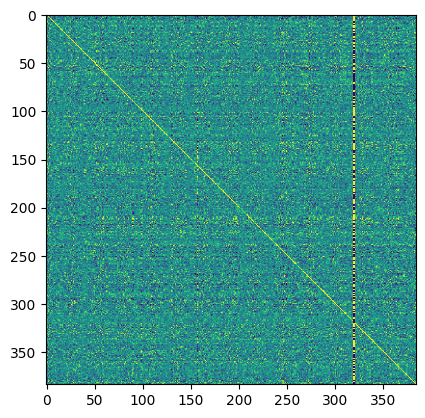

In [64]:
plt.imshow(map_emb_query_to_answer,vmin=-.1,vmax=.1)

#### Benchmark

In [65]:
train_ratio = 0.75

In [66]:
data_len = len(starkqa_df)
train_len = int(data_len*train_ratio)
train_len, data_len

(8403, 11204)

In [67]:
mask_train = random_mask(data_len,train_len)
mask_test = ~mask_train
sum(mask_test)

2801

In [68]:
txt1 = "StarkQA dataset: {} QA pairs, train ratio: {:.2f}, train/test size: {}/{}".format(data_len, train_ratio, sum(mask_train), sum(mask_test))
txt2 = "PrimeKG nodes: {}".format(len(primekg))
header_txt = "{}\n{}".format(txt2,txt1)
print(header_txt)

PrimeKG nodes: 8100498
StarkQA dataset: 11204 QA pairs, train ratio: 0.75, train/test size: 8403/2801


In [69]:
# reduce full data to training data
embeddings_queries_train = embeddings_queries[mask_train]
embedding_answers_train = embedding_answers[mask_train]
embeddings_queries_train_inv = np.linalg.pinv(embeddings_queries_train.T)

embeddings_queries_train.shape, embedding_answers_train.shape, embeddings_queries_train_inv.shape

((8403, 384), (8403, 384), (8403, 384))

In [70]:
# use other data as test data
embeddings_queries_test = embeddings_queries[mask_test] # these queries were not seen before
embeddings_queries_test.shape

(2801, 384)

In [88]:
answer_ids_list_test = list(np.array(answer_ids_list,dtype=object)[mask_test]) # true answers from test set
len(answer_ids_list_test)

2801

In [71]:
# project test queries on training queries
query_decomposed = np.dot(embeddings_queries_train_inv, embeddings_queries_test.T).T
query_decomposed.shape # every query from test set has answer weights from nodes from train set

(2801, 8403)

In [72]:
# linear combination: coefficients from query decomposition
query_answer = np.dot(query_decomposed, embedding_answers_train)
query_answer.shape # every answer from test query has its embedding

(2801, 384)

In [73]:
# and every node has its embedding, since the nodes are possible answers, compare them with the query answer embedding
embeddings_nodes.shape

(129375, 384)

In [87]:
distances = np.array([np.linalg.norm(query_answer_ - embeddings_nodes, axis=1) for query_answer_ in tqdm(query_answer)])
distances.shape

100%|████████████████████████████████████████████████████████████| 2801/2801 [08:47<00:00,  5.31it/s]


(2801, 129375)

In [89]:
# find where the answer was found at which position in rank distances
# if there are several true answers, find all their rank and get mean and min (maybe one true answer was ranked high but others were found later)

In [93]:
order_ratio_qa_list = []

for dist,aids in tqdm(zip(distances,answer_ids_list_test), total=len(distances)):
    #print(dist,aids)
    dist_indxsort = np.argsort(dist)
    order_ratio_list = []
    for aid in aids:
        #print(aid)
        order_found = np.argwhere(dist_indxsort==aid)[0][0]
        order_ratio = order_found / len(dist_indxsort) # quantile order
        order_ratio_list.append(order_ratio)
    order_ratio_mean = np.mean(order_ratio_list)
    order_ratio_min = np.min(order_ratio_list)
    order_ratio_qa_list.append([order_ratio_mean,order_ratio_min])

order_ratio_qa_list = np.array(order_ratio_qa_list)
order_ratio_qa_list.shape

100%|███████████████████████████████████████████████████████████| 2801/2801 [00:27<00:00, 102.92it/s]


(2801, 2)

In [135]:
order_ratio_qa_list_meanrank,order_ratio_qa_list_minrank = order_ratio_qa_list.T
order_ratio_qa_list_meanrank.shape, order_ratio_qa_list_minrank.shape

((2801,), (2801,))

In [136]:
order_list_rank_labels = ["mean rank", "min rank"]

In [137]:
for o_list,o_label in zip(order_ratio_qa_list.T, order_list_rank_labels):
    print("# {}".format(o_label))
    o_mean, o_median = np.mean(o_list), np.median(o_list)
    print("mean: {:.3f}".format(o_mean))
    print("median: {:.3f}".format(o_median))

# mean rank
mean: 0.043
median: 0.016
# min rank
mean: 0.034
median: 0.005


In [152]:
colors = ['orange','darkblue']

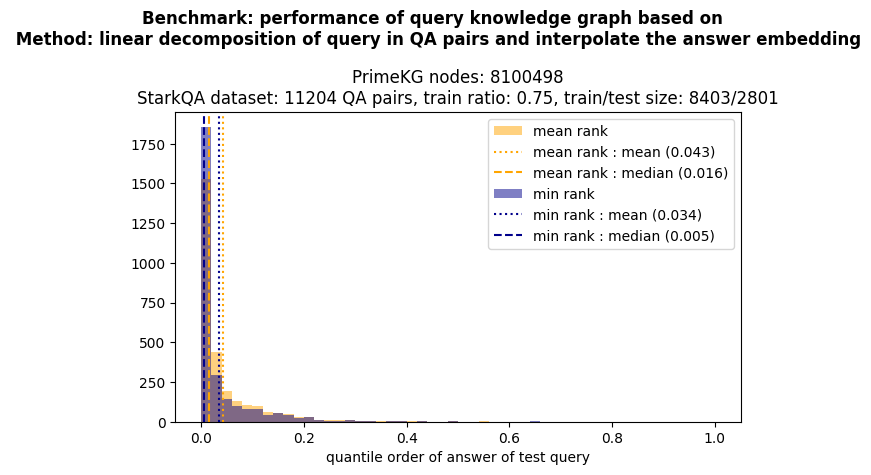

In [155]:
for o_list,o_label,o_color in zip(order_ratio_qa_list.T, order_list_rank_labels, colors):
    plt.hist(o_list, label=o_label, color=o_color, range=(0,1), bins=50, alpha=.5) #  density=True
    o_mean, o_median = np.mean(o_list), np.median(o_list)
    plt.axvline(x=o_mean, label="{} : mean ({:.3f})".format(o_label,o_mean), color=o_color, ls='dotted')
    plt.axvline(x=o_median, label="{} : median ({:.3f})".format(o_label,o_median), color=o_color, ls='dashed')

plt.xlabel("quantile order of answer of test query")
plt.suptitle("Benchmark: performance of query knowledge graph based on \n Method: linear decomposition of query in QA pairs and interpolate the answer embedding", fontweight="bold")
plt.title(header_txt)
plt.legend()
plt.tight_layout()
plt.show()

#### Benchmark (2)

In [76]:
# reduce full data to training data
embeddings_queries_train = embeddings_queries[mask_train]
embedding_answers_train = embedding_answers[mask_train]
embeddings_queries_train.shape, embedding_answers_train.shape

((8403, 384), (8403, 384))

In [77]:
# build the linear map: Q->A
map_emb_query_to_answer_train = np.dot(embedding_answers_train.T, np.linalg.pinv(embeddings_queries_train).T)
map_emb_query_to_answer_train.shape

(384, 384)

In [85]:
# use other data as test data
embeddings_queries_test = embeddings_queries[mask_test] # these queries were not seen before
embedding_answers_test = embedding_answers[mask_test] # their correct answers
embeddings_queries_test.shape, embedding_answers_test.shape

((2801, 384), (2801, 384))

In [79]:
# apply map on test set
query_answer_test = np.dot(map_emb_query_to_answer_train, embeddings_queries_test.T).T
query_answer_test.shape

(2801, 384)

In [126]:
distances = np.array([ [np.linalg.norm(query_answer_-embeddings_nodes, axis=1), 1-cosine_similarity([query_answer_],embeddings_nodes)] for query_answer_ in tqdm(query_answer_test)])
distances.shape

 12%|███████▏                                                     | 329/2801 [02:17<17:18,  2.38it/s]
KeyboardInterrupt



## Graph

In [ ]:
primekg.groupby(by=["x_type","y_type"])["relation"].value_counts()

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_pandas_edgelist(df=primekg, source='x_index', target='y_index', edge_attr='relation', create_using=nx.DiGraph)

In [ ]:
len(G.nodes)

In [ ]:
len(G.edges)

In [ ]:
# TODO: use graph to find target node, including similarity of query to nodes and edges